In [179]:
import numpy as np
import time
import matplotlib.pyplot as plt # For other plotting

In [180]:
# Load in and reshape data
start = time.time() # Code start time
sub_data = np.load('./subdata.npy') # Loads in flattened array of 3D data
time_steps = sub_data.shape[1] # Number of time steps
sub_data.shape

(262144, 49)

In [181]:
# Define Normal Space Parameters
L = 10 # Length of side
N = 64 # Size of grid in each direction
x = np.linspace(-L, L, N+1) # spatial x grid
x = x[:-1] # Take first N points
y = x; z = x # Same discretation in other dimensions
x_grid, y_grid, z_grid = np.meshgrid(x, y, z) # Generate meshgrid Tak\

In [182]:
# Define Fourier Space Parameters
# NOTE: Take out -1 from fourier vector as numpy doesn't include upper endpoint
kx = 2 * np.pi/(2 * L) * np.hstack((np.arange(0, N/2), np.arange(-N/2, 0))) # Define base kx vector, fourier order
kx = np.fft.fftshift(kx) # Apply fftshift for proper order of items
ky = kx; kz = kx # Same fourier discretation in all dimensions
kx_grid, ky_grid, kz_grid = np.meshgrid(kx, ky, kz)

In [183]:
# Calculate FFT of each time step
sub_data_fft = np.empty((N, N, N, time_steps), dtype='complex_') # Need to allow for complex values
for i in range(time_steps): # Iterate through all 3D slices
    sub_signal = np.reshape(sub_data[:, i], (N, N, N), 'F')
    sub_signal_fft = np.fft.fftn(sub_signal)
    sub_data_fft[:,:,:,i] = np.fft.fftshift(sub_signal_fft) # Add each element to result

In [184]:
# Average data to remove noise
sub_data_fft_avg = np.sum(sub_data_fft, axis=3) / time_steps # Average data
norm_frequencies = np.abs(sub_data_fft_avg) / np.abs(sub_data_fft_avg).max() # Normalize frequencies

In [185]:
# Get location of max frequency
max_idx = np.argmax(norm_frequencies)
x_loc, y_loc, z_loc = np.unravel_index(max_idx, sub_data_fft_avg.shape) # Linear index to matrix form (column major)
x_freq = kx_grid[x_loc, y_loc, z_loc].flatten() # Extract x frequency(ies)
y_freq = ky_grid[x_loc, y_loc, z_loc].flatten() # Extract y frequency(ies)
z_freq = kz_grid[x_loc, y_loc, z_loc].flatten() # Extract z frequency(ies)
print(x_loc, y_loc, z_loc) # Print Locations
print(x_freq, y_freq, z_freq) # Print frequencies

10 49 39
[5.34070751] [-6.91150384] [2.19911486]


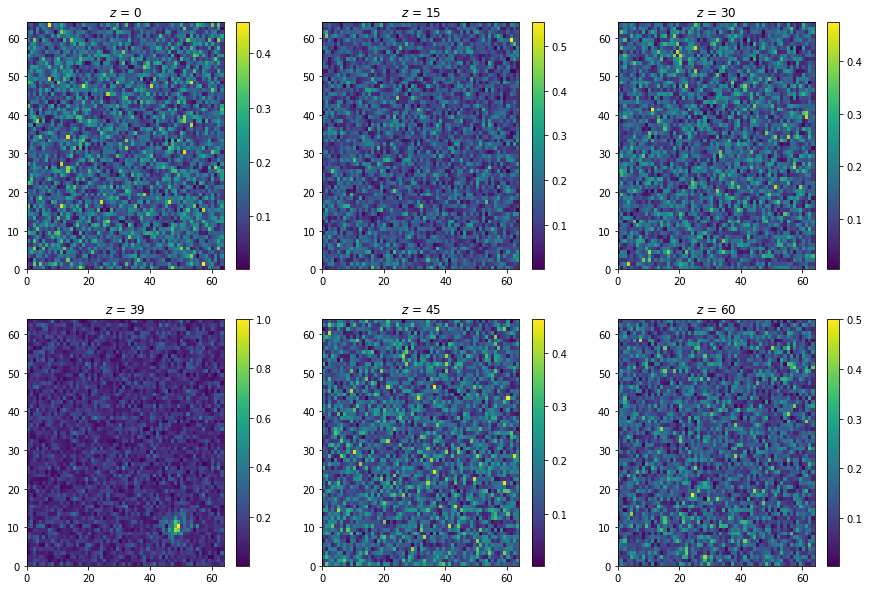

In [186]:
# Plot colormesh for max_idx
plot_idxs = [0, 15, 30, z_loc, 45, 60]
fig = plt.figure(figsize=(15, 10))

for i in range(1, len(plot_idxs) + 1):
    plt.subplot(2, len(plot_idxs) // 2 , i)
    fft_plot = norm_frequencies[:, :, plot_idxs[i-1]] # Data to Plot
    f = plt.pcolormesh(fft_plot)
    plt.colorbar(f)
    plt.title('$z$ = ' + str(plot_idxs[i-1]))

plt.savefig('2D Averaged Frequency Slices.png', bbox_inches='tight')
plt.show()

In [187]:
# Create Gaussian Filter using central frequency
sigma = 2 # variable spread, but assuming sigma_x = sigma_y = sigma_z = sigma
gauss_filt = np.exp(-0.5 * ((kx_grid - x_freq[0])**2  + (ky_grid - y_freq[0])**2 + (kz_grid - z_freq[0])**2) / sigma**2)

In [188]:
# Use Gaussian filter to de-noise and locate the data
position_data = np.empty((time_steps, 3)) # For storing locations
z_slice_plots = [] # For plotting z slices

for i in range(time_steps): # Iterate through data
    sub_loc_fft = sub_data_fft[:, :, :, i] # Access the FFT data (already shifted)
    sub_loc_fft_filt = sub_loc_fft * gauss_filt # Apply filter
    sub_loc_fft_filt = np.fft.ifftshift(sub_loc_fft_filt) # Shift data back
    sub_loc_filt = np.abs(np.fft.ifftn(sub_loc_fft_filt)) # inverse transform and abs value
    freq_location = np.argmax(sub_loc_filt) # Find argmax
    x_loc, y_loc, z_loc = np.unravel_index(freq_location, sub_loc_filt.shape) # Get 3D indexes
    
    if i % 10 == 0 or i == time_steps - 1: # Store sub main frequency slices to plot
        z_slice_plots.append((sub_loc_filt[:, :, z_loc], i, z_loc))
        
    # Find real space locations of data
    x_loc, y_loc, z_loc = x_grid[x_loc, y_loc, z_loc], y_grid[x_loc, y_loc, z_loc], z_grid[x_loc, y_loc, z_loc] # Get problem space locations
    position_data[i, :] = [x_loc, y_loc, z_loc] # Append

print(position_data[-1, :]) # Print Final Location

[-5.3125  0.9375  6.25  ]


In [189]:
# Write to CSV
import pandas as pd
table_dat = pd.DataFrame(position_data)
table_dat.index = 0.5 * np.arange(49) # Convert index to time
table_dat.columns = ['x', 'y', 'z'] # Set column names
table_dat = table_dat.iloc[0::6] # Select rows
table_dat = table_dat.T # Transpose
table_dat.to_csv('./Submarine Position Data.csv')

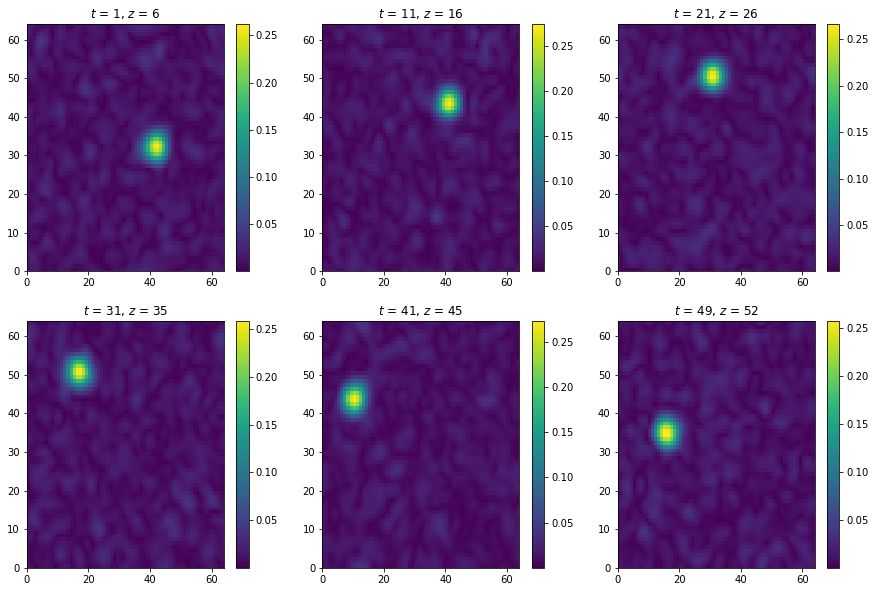

In [190]:
# Plot specific z slices
fig = plt.figure(figsize=(15, 10))

for i, z_slice in enumerate(z_slice_plots): # Iterate through all and add to subplots
    plt.subplot(2, len(z_slice_plots) // 2, i+1)
    fft_plot = z_slice[0]
    f = plt.pcolormesh(fft_plot)
    plt.colorbar(f)
    plt.title('$t$ = ' + str(z_slice[1]+1) + ', $z$ = ' + str(z_slice[2]))

# Show/Save Plot
plt.savefig('2D Submarine Frequency Signatures.png', bbox_inches='tight')
plt.show()

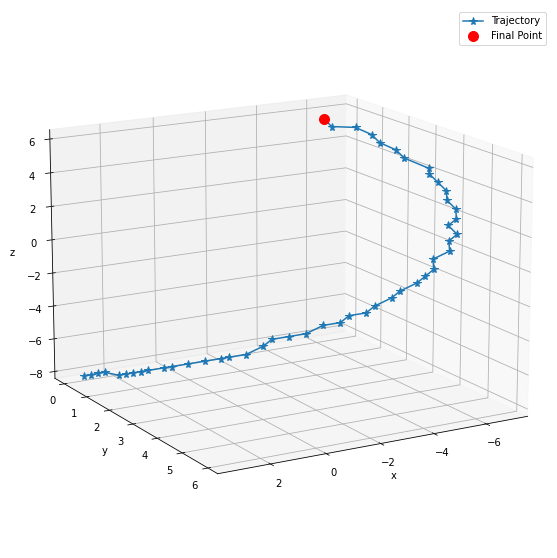

In [191]:
# Plot 3D Position
fig = plt.figure(figsize=(10,10)) # Generate subplots

# 3D Position Plot
ax0 = plt.axes(projection='3d');
ax0.plot(position_data[:, 0], position_data[:, 1], position_data[:, 2], '-*',
        markersize=8, label='Trajectory')
plt.plot(position_data[-1, 0], position_data[-1, 1], position_data[-1, 2],
        'ro', markersize=10, label='Final Point')
ax0.set_xlabel('x'); ax0.set_ylabel('y'); ax0.set_zlabel('z')
ax0.autoscale() # Autoscale axes
ax0.view_init(15,60)

# Show/Save Plot
plt.legend()
plt.savefig('3D_Sub_Location.png', bbox_inches='tight')
plt.show()

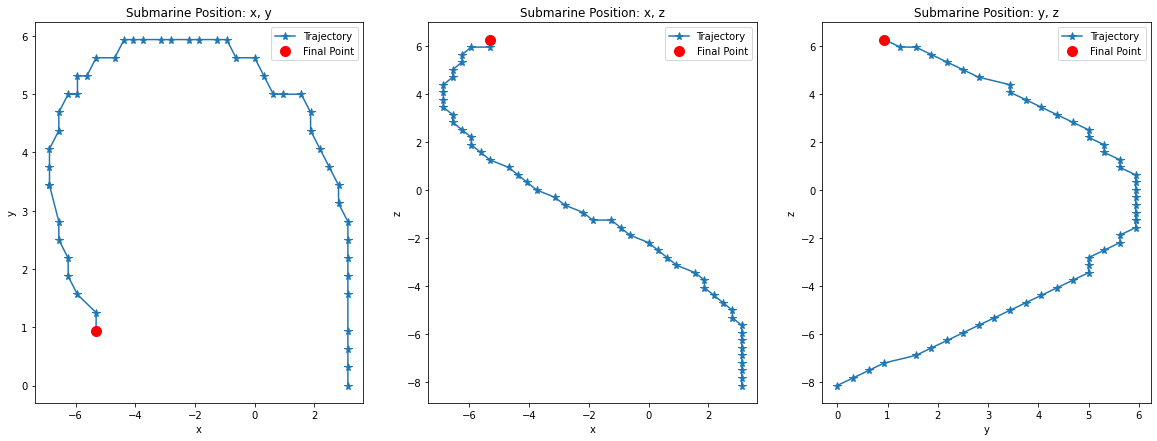

In [192]:
# 2D Projections
fig = plt.figure(figsize=(20, 7))

# x, y position
plt.subplot(1,3,1)
plt.plot(position_data[:, 0], position_data[:, 1], '-*', 
         label='Trajectory', markersize=8)
plt.plot(position_data[-1, 0], position_data[-1, 1], 'ro', 
         label='Final Point', markersize=10)
plt.xlabel('x'); plt.ylabel('y');
plt.title('Submarine Position: x, y')
plt.legend()

# x, z position
plt.subplot(1,3,2)
plt.plot(position_data[:, 0], position_data[:, 2], '-*', 
         label='Trajectory', markersize=8)
plt.plot(position_data[-1, 0], position_data[-1, 2], 'ro', 
         label='Final Point', markersize=10)
plt.xlabel('x'); plt.ylabel('z');
plt.title('Submarine Position: x, z')
plt.legend()

# y, z position
plt.subplot(1,3,3)
plt.plot(position_data[:, 1], position_data[:, 2], '-*', 
         label='Trajectory', markersize=8)
plt.plot(position_data[-1, 1], position_data[-1, 2], 'ro', 
         label='Final Point', markersize=10)
plt.xlabel('y'); plt.ylabel('z');
plt.title('Submarine Position: y, z')
plt.legend()

# Show Plot
plt.savefig('2D_Sub_Locations.png', bbox_inches='tight')
plt.show()

In [193]:
# Code Run time
end = time.time()
print('Code Completed in: ' + str(round(end - start, 3)) + ' sec')

Code Completed in: 5.242 sec
